In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%config InlineBackend.figure_format = 'retina'
from DS_detector import rematch_cat

In [2]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')

In [3]:
df = df[df['status'] != 'fp']
df = df[df['catalog'] != 'planck_no_z']
df.index = np.arange(len(df))

In [4]:
q_z = [df['z'].quantile(i/6) for i in range(0, 7)]
q_z[0] = 0
q_z[-1] = 2
q_m = [df['M500'].quantile(i/10) for i in range(0, 11)]
q_m[0] = 0
q_m[-1] = 20

In [5]:
q_m500 = {}
for i in range(len(q_z) - 1):
    st = q_z[i]
    en = q_z[i + 1]
    matched = np.logical_and(st <= df['z'], df['z'] < en)
    cur_df = df[matched]
    q_m500[en] = [cur_df['M500'].quantile(i / 10) for i in range(11)]
    q_m500[en][-1] = 20

In [6]:
q_m500 = pd.DataFrame(q_m500)
q_m500

,0.104883,0.190000,0.273000,0.364850,0.520000,2.000000
0,0.153200,0.621400,0.916500,1.181700,1.100300,1.420565
1,1.160940,1.738468,2.130742,2.134707,2.137213,2.126349
2,1.522394,2.209128,2.865830,2.733124,2.635548,2.436247
3,1.784133,2.655854,3.431312,3.320552,3.005195,2.775222
4,1.928635,3.020204,3.843740,4.316150,3.538795,3.144469
5,2.212115,3.348598,4.203834,4.768429,4.177817,3.631107
6,2.404018,3.634318,4.494722,5.168771,5.168618,4.165489
7,2.628148,3.961354,4.947573,5.516936,5.715267,5.172333
8,3.100600,4.444562,5.681092,5.961347,6.202514,6.112604
9,4.055416,5.377776,6.641820,6.811468,7.231913,6.979303


In [7]:
pred_ind_mean = []
for j in range(len(q_m500[q_z[1]]) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_m500[z_en][j]
        m_en = q_m500[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        pred_ind = cur_df['max_pred'].mean()
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = pred_ind
    pred_ind_mean.append(pd.DataFrame(line, index=[j]))
pred_ind_mean = pd.concat(pred_ind_mean)

In [8]:
cm = sns.light_palette("green", as_cmap=True)

s = pred_ind_mean.style.background_gradient(cmap=cm)
s

,"(0.00,0.10)","(0.10,0.19)","(0.19,0.27)","(0.27,0.36)","(0.36,0.52)","(0.52,2.00)"
0,0.490359,0.491968,0.427658,0.418495,0.424075,0.329423
1,0.633045,0.564677,0.540438,0.438732,0.409315,0.340213
2,0.704928,0.605852,0.591572,0.595685,0.440830,0.390170
3,0.730077,0.719664,0.726743,0.640293,0.449520,0.392807
4,0.778635,0.746694,0.839445,0.730271,0.536273,0.467314
5,0.849831,0.786106,0.847132,0.824014,0.690590,0.389790
6,0.854648,0.911559,0.918785,0.880499,0.771985,0.504318
7,0.899797,0.861884,0.928800,0.904850,0.821450,0.708796
8,0.888240,0.963831,0.955885,0.936929,0.941501,0.753538
9,0.990523,0.991749,0.991836,0.973034,0.975293,0.941345


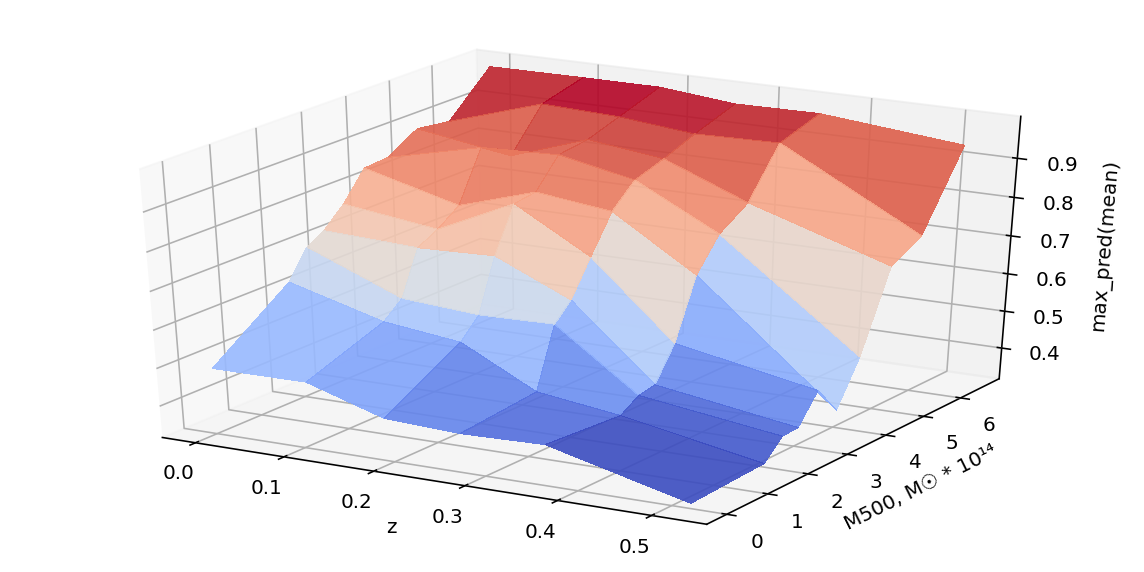

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))
X, Y = np.meshgrid(q_z[:-1], q_m[:-1])

Z = np.zeros_like(X)

ax.set_zticks(np.arange(0, 1.1, 0.1))
cols = list(pred_ind_mean)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = pred_ind_mean[cols[j]].iloc[i]
#X, Y = np.meshgrid(list(range(len(q_z) - 1)), list(range(len(q_m) - 1)))
        
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.9)

# Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('z')
ax.set_ylabel('M500, M☉ * 10¹⁴')
ax.set_zlabel('max_pred(mean)')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()